In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import *

In [2]:
k = 2
m = 30
n = 5000

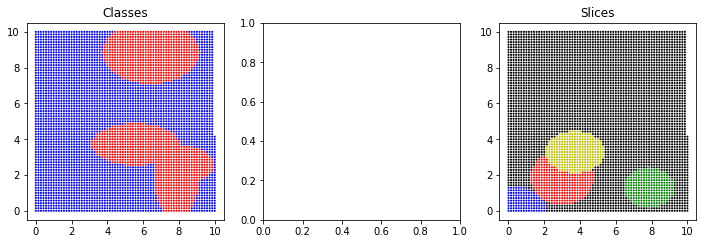

In [3]:
L, X, Y, Z = generate_dataset(k, m, n)

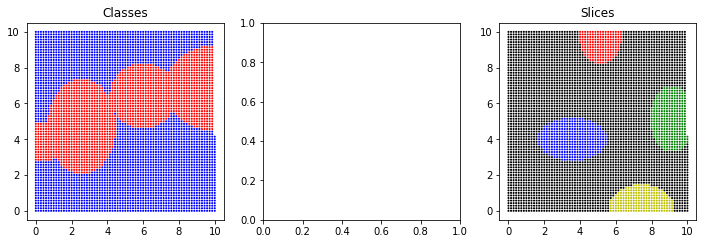

In [39]:
L, X, Y, Z, targeting_lfs_idx = generate_dataset(k, m, n, return_targeting_lfs=True)

### Analyze Data

In [4]:
from scipy.sparse import csr_matrix
import torch

L = csr_matrix(L)
X = torch.Tensor(X)

In [5]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True, seed=123)

In [6]:
from metal.analysis import lf_summary

lf_summary(Ls[1], Ys[1])

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.054,0.054,0.042,14,13,0.518519
1,"[1, 2]",0.082,0.082,0.074,32,9,0.780488
2,"[1, 2]",0.174,0.174,0.120,75,12,0.862069
3,"[1, 2]",0.082,0.082,0.068,25,16,0.609756
4,"[1, 2]",0.022,0.020,0.012,7,4,0.636364
5,"[1, 2]",0.020,0.020,0.014,5,5,0.500000
6,"[1, 2]",0.218,0.208,0.136,94,15,0.862385
7,"[1, 2]",0.244,0.244,0.196,102,20,0.836066
8,"[1, 2]",0.078,0.078,0.066,21,18,0.538462
9,"[1, 2]",0.010,0.008,0.004,2,3,0.400000


In [7]:
# num_votes = Ls[0].sum(axis=1)
# plt.hist(num_votes)

In [8]:
# np.save('synthetic_data.npy', (L, Y))

# Learn

In [9]:
# L, Y = np.load('synthetic_data.npy')

### Snorkel LabelModel

In [11]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

Inferred cardinality: 2


In [12]:
from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_p = label_model.predict(Ls[0])

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.82

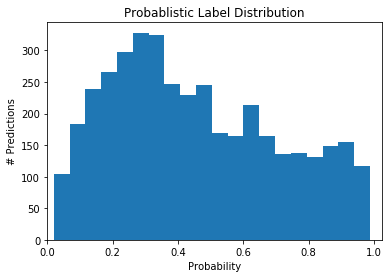

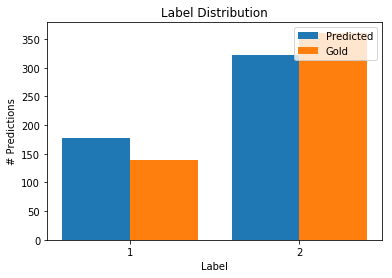

In [13]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)
    
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

### EndModel

In [14]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

train_loader = DataLoader(
    SlicingDataset(Xs[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

In [15]:
from metal.end_model import EndModel
import torch

end_model = EndModel([2,10,10,2])
end_model.train_model(train_loader, dev_data=(Xs[1], Ys[1]), l2=0.0, 
                      n_epochs=25, print_every=5, validation_metric='accuracy', 
                      disable_prog_bar=True)
end_model.score((Xs[1], Ys[1]))


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Saving model at iteration 0 with best score 0.642
[E:0]	Train Loss: 181.140	Dev accuracy: 0.642
[E:5]	Train Loss: 170.884	Dev accuracy: 0.640
Saving model at iteration 7 with best score 0.660
[E:10]	Train Loss: 170.229	Dev accuracy: 0.638
Saving model at iteration 11 with best score 0.680
Saving model at iteration 14 with best score 0.692
Saving model at iteration 15 with best score 0.696
[E:15]	Train Loss: 169.800	Dev accuracy: 0.696
Saving model at iteration 16 with best score 0.710
Saving model at iteration 18 with best score 0.718
Saving model at iteration 20 with best score 0.760
[E:20]	Train Loss: 169.209	Dev accuracy: 0.760
Saving model at iteration 21 with best score 

0.786

### SliceModel

In [16]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

dev_loader = DataLoader(
    SlicingDataset(Xs[1], Ys[1]),
    batch_size=256,
)

In [17]:
import torch.nn as nn
from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule

n, m = Ls[0].shape
input_dim = Xs[0].shape[1]

input_module = MLPModule(input_dim, 10, [10], bias=True)
slice_model = SliceDPModel(input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
                           verbose=False)
slice_model.train_model(
    train_loader,
    dev_data=dev_loader,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/dfs/scratch0/vschen/metal/metal/contrib/slicing/online_dp.py:201: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.forward_Y(x)).data.cpu().numpy()


Saving model at iteration 0 with best score 0.652
[E:0]	Train Loss: 153.947	Dev accuracy: 0.652
Saving model at iteration 2 with best score 0.730
Saving model at iteration 3 with best score 0.736
[E:5]	Train Loss: 151.337	Dev accuracy: 0.736
[E:10]	Train Loss: 150.278	Dev accuracy: 0.676
Saving model at iteration 12 with best score 0.764
Saving model at iteration 13 with best score 0.792
Saving model at iteration 15 with best score 0.800
[E:15]	Train Loss: 148.783	Dev accuracy: 0.800
Saving model at iteration 18 with best score 0.806
Saving model at iteration 20 with best score 0.812
[E:20]	Train Loss: 148.077	Dev accuracy: 0.812
Saving model at iteration 21 with best score 0.814
Saving model at iteration 22 with best score 0.824
[E:25]	Train Loss: 147.465	Dev accuracy: 0.792
Saving model at iteration 26 with best score 0.826
Saving model at iteration 28 with best score 0.834
[E:30]	Train Loss: 147.234	Dev accuracy: 0.826
[E:35]	Train Loss: 147.089	Dev accuracy: 0.820
Saving model at i

### New SliceModel

In [18]:
from metal.contrib.slicing.online_dp import SliceHatModel

# base_model = EndModel([2,20,20,2], verbose=False)
slicer = SliceHatModel(end_model, m, slice_weight=0.1)

slicer.train_model(
    train_loader,
    dev_data=dev_loader,
    lr=0.05,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=10, out_features=30, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)



/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Saving model at iteration 0 with best score 0.722
[E:0]	Train Loss: 0.617	Dev accuracy: 0.722
[E:5]	Train Loss: 0.605	Dev accuracy: 0.664
Saving model at iteration 10 with best score 0.724
[E:10]	Train Loss: 0.604	Dev accuracy: 0.724
Saving model at iteration 11 with best score 0.824
Saving model at iteration 12 with best score 0.846
[E:15]	Train Loss: 0.590	Dev accuracy: 0.826
Saving model at iteration 17 with best score 0.848
Saving model at iteration 18 with best score 0.856
Saving model at iteration 19 with best score 0.876
[E:20]	Train Loss: 0.584	Dev accuracy: 0.856
Saving model at iteration 23 with best score 0.900
[E:25]	Train Loss: 0.581	Dev accuracy: 0.888
[E:30]	Train Loss: 0.578	Dev accuracy: 0.892
[E:35]	Train Loss: 0.577	Dev accuracy: 0.898
Saving model at iteration 36 with best score 0.908
[E:40]	Train Loss: 0.576	Dev accuracy: 0.896
[E:45]	Train Loss: 0.576	Dev accuracy: 0.892
[E:49]	Train Loss: 0.575	Dev accuracy: 0.890
Restoring best model from iteration 36 with score

In [19]:
from metal.contrib.slicing.utils import evaluate_slicing

from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

_ = evaluate_slicing(end_model, eval_loader, verbose=False)
_ = evaluate_slicing(slice_model, eval_loader, verbose=False)
_ = evaluate_slicing(slicer, eval_loader, verbose=False)

100%|██████████| 500/500 [00:00<00:00, 8217.65it/s]


SUMMARY (accuracies):
All: 0.786
Slice 0: 0.7790973871733967
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 0.85
Slice 4: 0.56



100%|██████████| 500/500 [00:00<00:00, 10930.98it/s]


SUMMARY (accuracies):
All: 0.836
Slice 0: 0.828978622327791
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 0.85
Slice 4: 0.72



SUMMARY (accuracies):
All: 0.908
Slice 0: 0.9026128266033254
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 0.85
Slice 4: 0.92


In [20]:
# L_pred = np.round(slicer.predict_L_proba(Xs[1]).numpy())
# L_pred[L_pred == 0] = 2
# accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

In [21]:
# ((Ls[1] == L_pred).sum(axis=0)/(Ls[1] != 0).sum(axis=0)).mean()

### Repeated Trials

In [42]:
targeting_lfs_idx

[21, 8, 17, 19]

In [68]:
from metal.contrib.slicing.online_dp import SliceHatModel

model_configs = {
#     "EndModel": {
#         "base_model_class" : EndModel,
#         "base_model_init_kwargs": {
#             "layer_out_dims": [5, 2],
#             "input_layer_config": {
#                 "input_relu": False,
#                 "input_batchnorm": False,
#                 "input_dropout": 0.0,
#             }
#         },
#         "input_module_class": MLPModule,
#         "input_module_init_kwargs": {
#             'input_dim': 2,
#             'middle_dims': [5],
#             'bias': True,
#             'output_dim': 5
#          },
        
#         "train_on_L": False,
#         "L_weights": None
# #         "L_weights": accs
#     },
#     "Upweighted 2x": {
#         "base_model_class" : EndModel,
#         "base_model_init_kwargs": {
#             "layer_out_dims": [5, 2],
#             "input_layer_config": {
#                 "input_relu": False,
#                 "input_batchnorm": False,
#                 "input_dropout": 0.0,
#             }
#         },
#         "input_module_class": MLPModule,
#         "input_module_init_kwargs": {
#             'input_dim': 2,
#             'middle_dims': [5],
#             'bias': True,
#             'output_dim': 5
#          },
        
#         "train_on_L": False,
#         "L_weights": [2, 1, 1]
#     },
#     "MixtureOfExperts": {
#         "base_model_class" : EndModel,
#         "base_model_init_kwargs": {
#             "layer_out_dims": [5, 2],
#             "input_layer_config": {
#                 "input_relu": False,
#                 "input_batchnorm": False,
#                 "input_dropout": 0.0,
#             }
#         },
#         "input_module_class": MLPModule,
#         "input_module_init_kwargs": {
#             'input_dim': 2,
#             'middle_dims': [5],
#             'bias': True,
#             'output_dim': 5
#          },
        
#         "train_on_L": False,
#         "mixture_of_experts": True,
#         "L_weights": None
# #         "L_weights": accs

#     },
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 0.1
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
        "L_weights": None
#         "L_weights": accs

    }
}

---------- Training AttentionModel ----------
Inferred cardinality: 2
Slice Heads:
Reweighting: True
L_weights: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
Slice Weight: 0.1
Input Network: Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
)
L_head: Linear(in_features=5, out_features=30, bias=False)
Y_head: Linear(in_features=10, out_features=2, bias=True)
Criteria: BCEWithLogitsLoss() SoftCrossEntropyLoss()
Saving model at iteration 0 with be

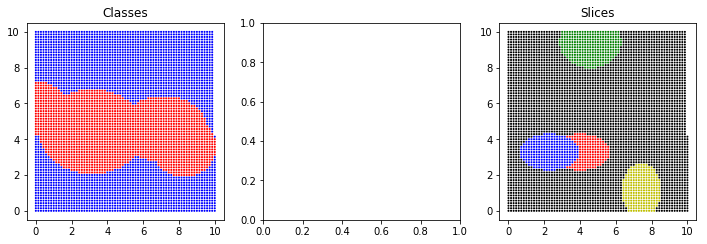

In [78]:
L, X, Y, Z, targeting_lfs_idx = generate_dataset(k, m, n, return_targeting_lfs=True)
Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)

L_weights = np.ones(m)
L_weights[targeting_lfs_idx] = 2
L_weights = list(L_weights)
# model_configs['Upweighted 2x']['L_weights'] = L_weights

from simulate import train_models

train_kwargs = {
    'print_every': 1,
    'l2': 0,
    'lr': 0.01,
    'n_epochs': 50,
    'batch_size': 32,
    'disable_prog_bar': True
}

# lm = SnorkelLabelModel()
# lm.train_model(Ls[0])
# Y_train_ps = lm.predict_proba(Ls[0])

trained_models = train_models(
    (Xs[0], Xs[1]),
    (np.array(Ls[0].todense()).astype(np.float32), np.array(Ls[1].todense()).astype(np.float32)),
    Ys[1],
    model_configs,
    train_kwargs,
    verbose=True
)


In [ ]:
# from metal.utils import split_data, SlicingDataset
# from metal.label_model.baselines import MajorityLabelVoter
# from metal.end_model import EndModel
# from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
# from metal.contrib.slicing.synthetics.geometric_synthetics import *
# from metal.contrib.slicing.online_dp import SliceHatModel
# from metal.contrib.slicing.utils import evaluate_slicing

# import torch
# from torch.utils.data import DataLoader

# NUM_TRIALS = 1
# SPLIT = 2

# k = 2
# m = 30
# n = 5000

# batchsize = 32
# layer_output_dims = [2, 10, 10, 2]


# summary = {}
# for model in ['mv', 'dp', 'up', 'me', 'sm']:
#     summary[model] = {
#         'overall': [],
#         'slices': []
#     }

# for i in range(NUM_TRIALS):
#     L, X, Y, Z = generate_dataset(k, m, n, plotting=True)
#     Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)
    
#     lm = SnorkelLabelModel()
#     lm.train_model(Ls[0])
#     Y_train_ps = lm.predict_proba(Ls[0])

#     dev_loader = DataLoader(
#         SlicingDataset(Xs[1], Ys[1]),
#         batch_size=256,
#     )
#     eval_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]))
    
#     # Train dp_em
#     em_train_loader = DataLoader(
#         SlicingDataset(Xs[0], Y_train_ps),
#         batch_size=batchsize,
#         shuffle=True
#     )    
    
#     dp_em = EndModel(layer_output_dims)
#     dp_em.train_model(
#         em_train_loader,
#         dev_data=dev_loader,
#         lr=0.05,
#         l2=0.0, 
#         n_epochs=50,
#         print_every=5, 
#         validation_metric='accuracy',
#         verbose=True, 
#         use_cuda=False,
#         disable_prog_bar=True,
#     )

#     dp_em_results = evaluate_slicing(dp_sm, eval_loader, verbose=False)
#     summary['em']['overall'].append(dp_sm_results['all']['accuracy'])
#     for s in range(1,5):
#         summary['em']['slices'].append(dp_sm_results[f'slice_{s}']['accuracy'])    
    
#     # Train dp_sm
#     L_train = torch.Tensor(np.asarray(Ls[0].todense()))    
#     sm_train_loader = DataLoader(
#         SlicingDataset(Xs[0], L_train, Y_train_ps),
#         batch_size=batchsize,
#         shuffle=True
#     )
    
#     dp_sm = SliceHatModel(dp_em, m, slice_weight=0.1)
#     dp_sm.train_model(
#         sm_train_loader,
#         dev_data=dev_loader,
#         lr=0.05,
#         l2=0.0, 
#         n_epochs=50,
#         print_every=5, 
#         validation_metric='accuracy',
#         verbose=True, 
#         use_cuda=False,
#         disable_prog_bar=True,
#     )
    
#     dp_sm_results = evaluate_slicing(dp_sm, eval_loader, verbose=False)
#     summary['sm']['overall'].append(dp_sm_results['all']['accuracy'])
#     for s in range(1,5):
#         summary['sm']['slices'].append(dp_sm_results[f'slice_{s}']['accuracy'])

# print(summary['em'])
# print(summary['sm'])

In [ ]:
#     lm_train_loader = DataLoader(SlicingDataset(Ls[0], Ys[0], Zs[0]), batch_size=batchsize)
#     lm_dev_loader = DataLoader(SlicingDataset(Ls[1], Ys[1], Zs[1]), batch_size=batchsize)
#     lm_test_loader = DataLoader(SlicingDataset(Ls[2], Ys[2], Zs[2]), batch_size=batchsize)

#     em_train_loader = DataLoader(SlicingDataset(Xs[0], Ys[0], Zs[0]), batch_size=batchsize)
#     em_dev_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]), batch_size=batchsize)
#     em_test_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]), batch_size=batchsize)
    
#     majority_voter = MajorityLabelVoter()
#     Y_train_ps = majority_voter.predict_proba(Ls[SPLIT])
#     mv_em = EndModel(layer_output_dims)
#     mv_em.train_model(em_train_loader, em_)
#     summary['mv']
    
#     label_model = SnorkelLabelModel()
#     label_model.train_model(Ls[0])
#     lm_results = evaluate_slicing(label_model, lm_eval_loader, verbose=False, break_ties=2)
